<a href="https://colab.research.google.com/github/Ved204/CP468-Facial-Recognition/blob/main/colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Facial Emotion Recognition

Project Configuration

In [ ]:
# Import Libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from tensorflow.python.keras.utils.np_utils import to_categorical
from keras.preprocessing.image import load_img
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D

In [ ]:
# Mount Drive
from google.colab import drive
import os

drive.mount('/content/drive')
kaggle_json_path = '/content/drive/MyDrive/CP468 Project/kaggle.json'

Mounted at /content/drive


In [ ]:
# Install Dataset
!pip install kaggle
! mkdir ~/.kaggle
! cp {kaggle_json_path} ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d aadityasinghal/facial-expression-dataset
! unzip facial-expression-dataset.zip

# Set File Paths
train_path = '/content/train/train/'
test_path = '/content/test/test/'

In [ ]:
# Load Dataset
def load_dataset(directory):
    image_paths = []
    labels = []

    for label in os.listdir(directory):
        for filename in os.listdir(directory+label):
            image_path = os.path.join(directory, label, filename)
            image_paths.append(image_path)
            labels.append(label)

        print(label, "Completed")

    return image_paths, labels

In [ ]:
# Convert training dataset into a dataframe
train = pd.DataFrame()
train['image'], train['label'] = load_dataset(train_path)

# Shuffle the dataset
train = train.sample(frac=1).reset_index(drop=True)
train.head()

# Convert testing dataset into a dataframe
test = pd.DataFrame()
test['image'], test['label'] = load_dataset(test_path)

# Shuffle the dataset
test = test.sample(frac=1).reset_index(drop=True)
test.head()

happy Completed
fear Completed
sad Completed
neutral Completed
angry Completed
surprise Completed
disgust Completed
happy Completed
fear Completed
sad Completed
neutral Completed
angry Completed
surprise Completed
disgust Completed


,image,label
0,/content/test/test/sad/PublicTest_86587530.jpg,sad
1,/content/test/test/fear/PrivateTest_53979011.jpg,fear
2,/content/test/test/happy/PublicTest_71400238.jpg,happy
3,/content/test/test/neutral/PublicTest_66168751...,neutral
4,/content/test/test/angry/PrivateTest_73130508.jpg,angry


Data Analysis

<Axes: xlabel='count', ylabel='label'>

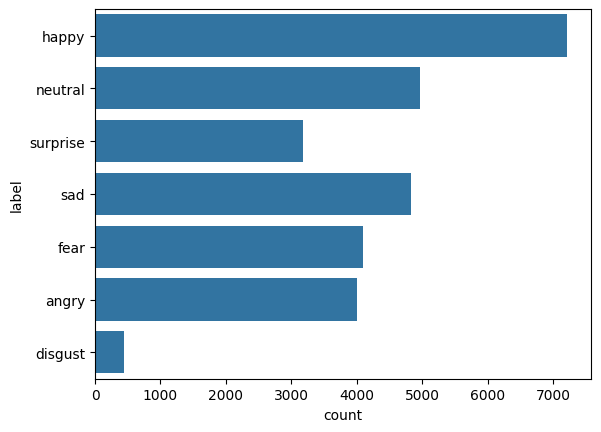

In [ ]:
# Plotting Frequency of Labels in training dataset
sns.countplot(train['label'])

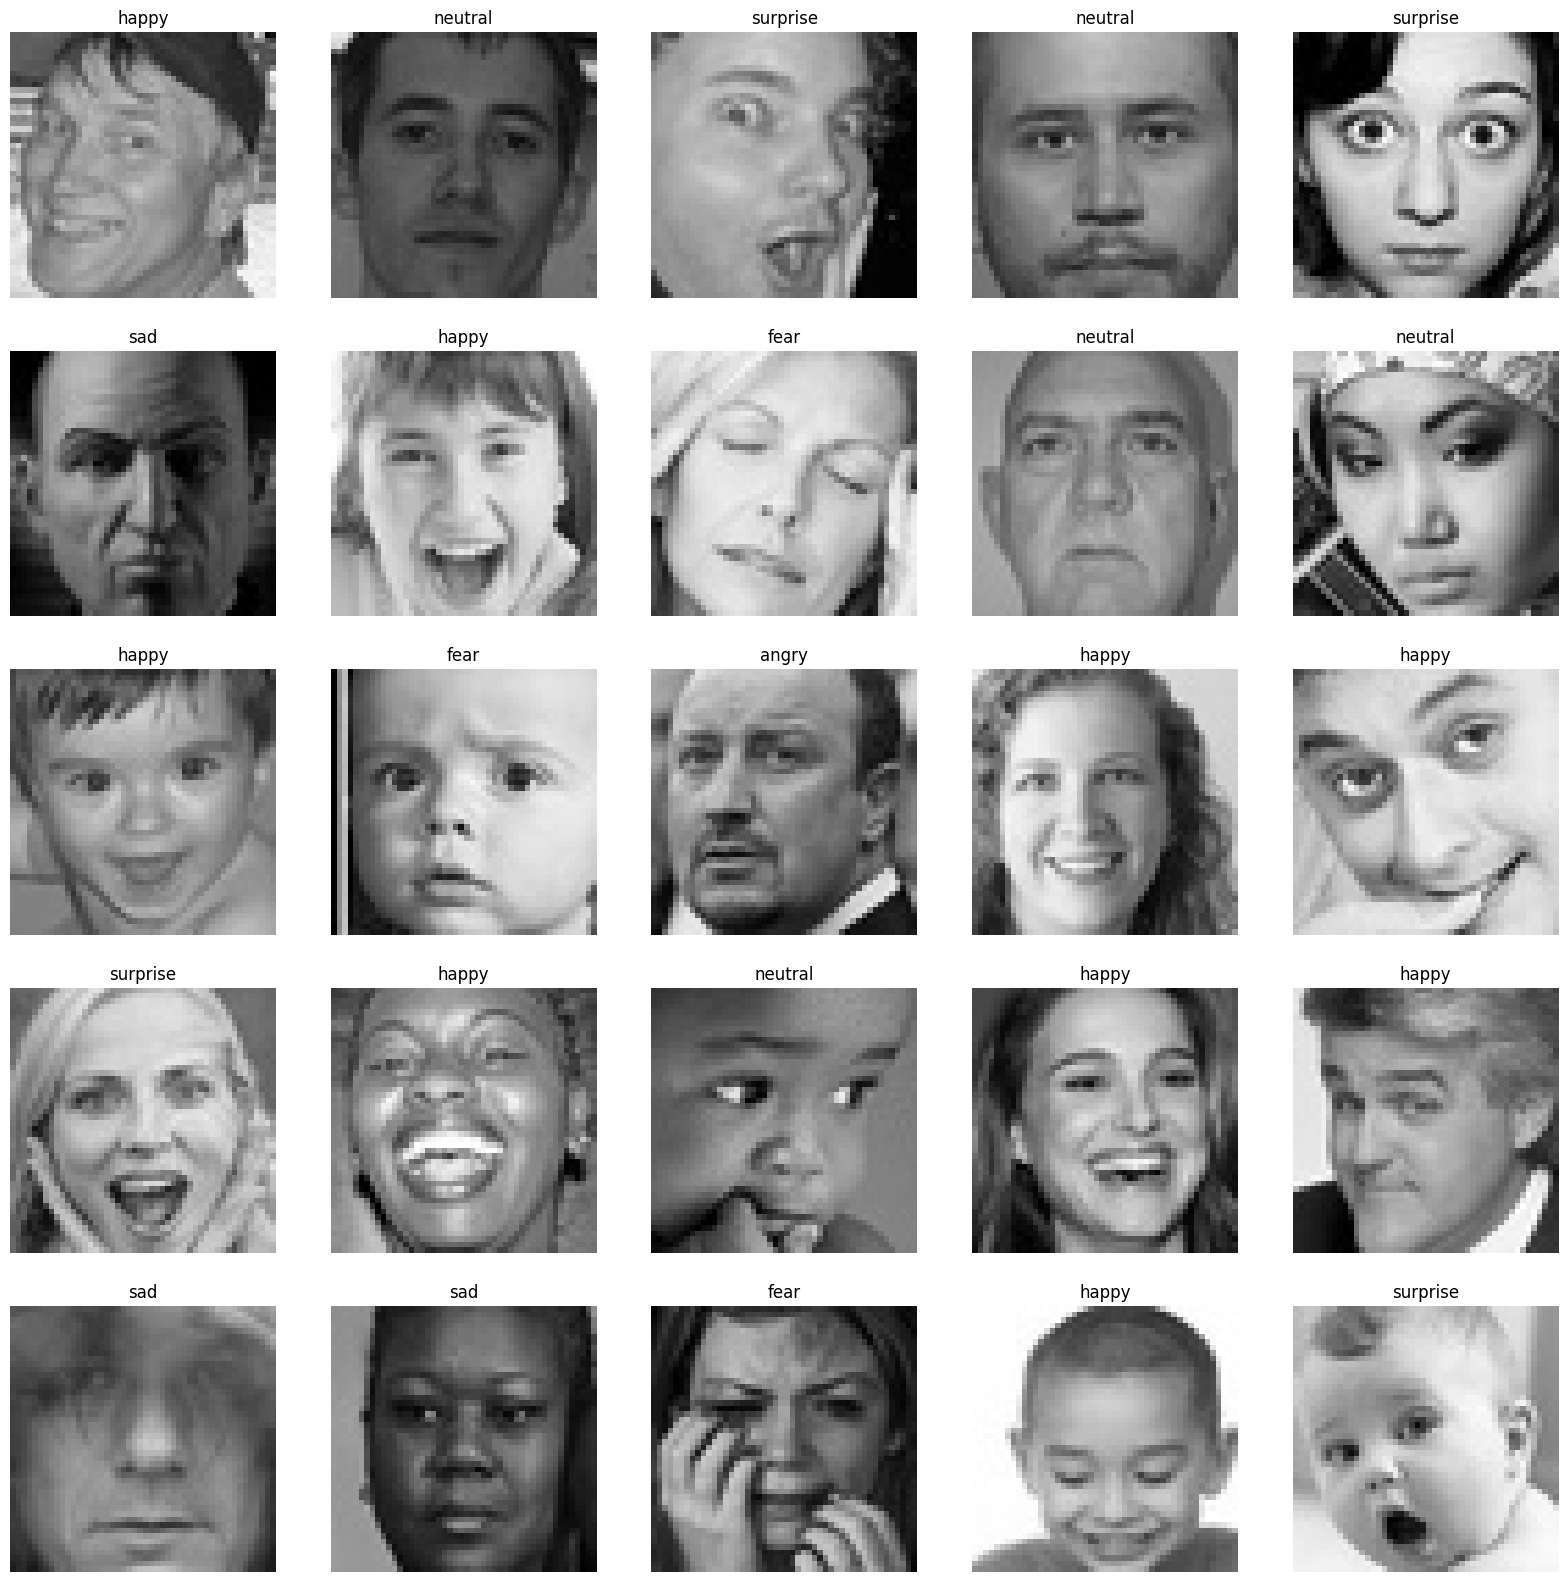

In [ ]:
# Sample Images from Training Dataset
from PIL import Image

# img = Image.open(train['image'][0])
# plt.imshow(img, cmap='gray');

plt.figure(figsize=(20,20))
files = train.iloc[0:25]

for index, file, label in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

Feature Extraction

In [ ]:
# Extract features from these images to use as input when training CNN
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, grayscale=True)
        img = np.array(img)
        features.append(img)
    features = np.array(features)
    features = features.reshape(len(features), 48, 48, 1)
    return features

In [ ]:
# Extract features for training dataset
train_features = extract_features(train['image'])

  0%|          | 0/28709 [00:00<?, ?it/s]

In [ ]:
# Extract features for testing dataset
test_features = extract_features(test['image'])

  0%|          | 0/7178 [00:00<?, ?it/s]

In [ ]:
# Normalize the Images to improve convergence of CNN
x_train = train_features/255.0
x_test = test_features/255.0

In [ ]:
# Transform Training Labels to Integer Labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['label'])
y_train = le.transform(train['label'])
y_test = le.transform(test['label'])

In [ ]:
# Convert the Integer Labels into a Binary Vector
y_train = to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)

In [ ]:
# Seeing how the vector looks like
y_train[0]

array([0., 0., 0., 1., 0., 0., 0.], dtype=float32)

In [ ]:
# Configuration for Model
input_shape = (48, 48, 1)
output_class = 7

Model Creation

In [ ]:
# Defining the Model
model = Sequential()

# Convolutional layers
model.add(Conv2D(128, kernel_size=(3,3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

# Flatten Layers
model.add(Flatten())

# Fully Conntected Layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))

# Output Layer using the softmax activation function
model.add(Dense(output_class, activation='softmax'))

# Compile Model using the Adam optimizer tracking accuracy and loss
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

In [ ]:
# Train the Model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(x_train)

# Early Stopping and Model Checkpoint
checkpoint_path = '/content/drive/MyDrive/CP468 Project/model_three/model_checkpoint.h5'
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')

# Train the Model
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=128),
    epochs=120,
    validation_data=(x_test, y_test),
    callbacks=[early_stopping, checkpoint]
)


In [ ]:
# Save Model
import pickle
history_path = '/content/drive/MyDrive/CP468 Project/model_three/history.pkl'
with open(history_path, 'wb') as file:
    pickle.dump(history.history, file)

Analyze and Plot Results

In [ ]:
# Load Model
from keras.models import load_model
import pickle

# Load the saved model
model = load_model('/content/drive/MyDrive/CP468 Project/model_three/model_checkpoint.h5')

# Load the history object
with open('/content/drive/MyDrive/CP468 Project/model_three/history.pkl', 'rb') as file:
    previous_history = pickle.load(file)

# Continue training the model
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=128),
    epochs=20,  # Set the number of additional epochs you want to train
    validation_data=(x_test, y_test),
    callbacks=[early_stopping, checkpoint]
)

# Merge previous history with new history
for key in previous_history:
    previous_history[key].extend(history.history[key])

# Save the updated history back to file
with open(history_path, 'wb') as file:
    pickle.dump(previous_history, file)


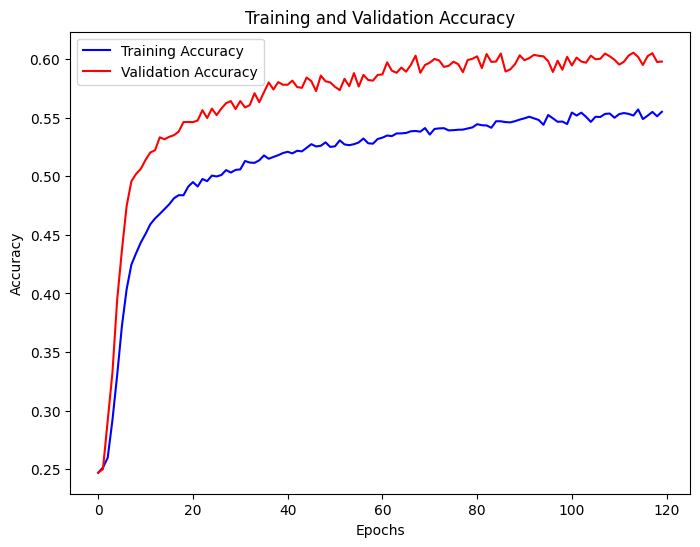

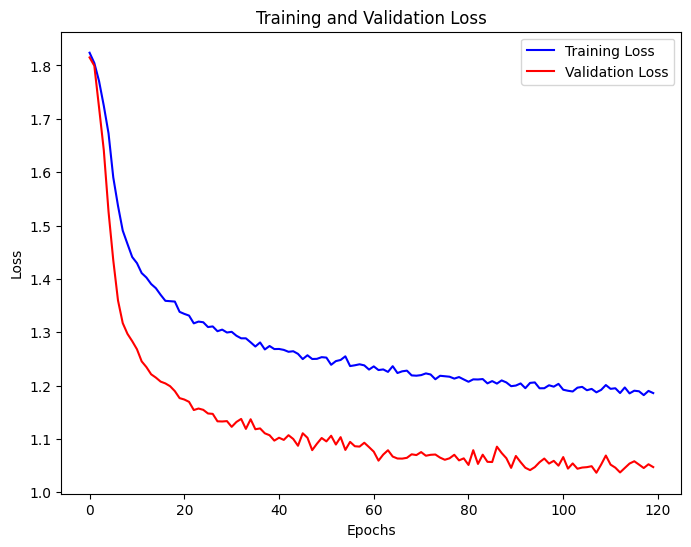

225/225 [==============================] - 1s 4ms/step


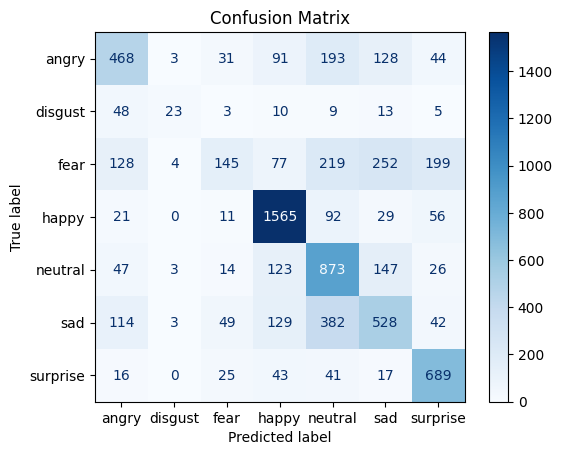

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Accuracy and Loss Graph with Axis Labels
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

# Plot Accuracy
plt.figure(figsize=(8, 6))
plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot Loss
plt.figure(figsize=(8, 6))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Confusion Matrix
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

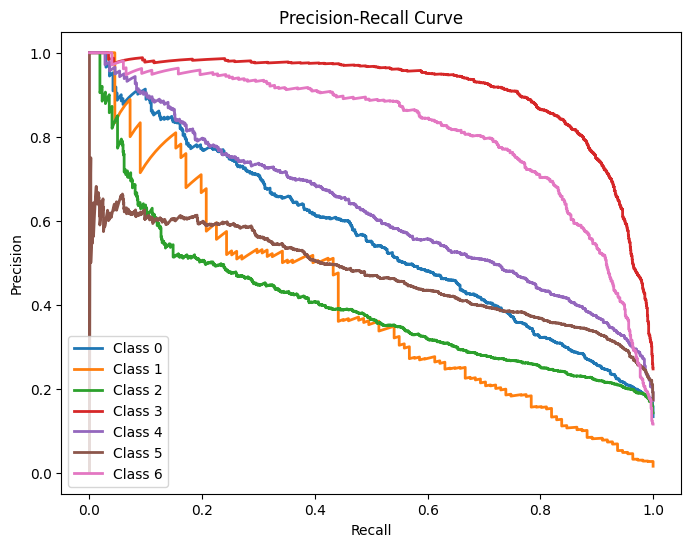

In [ ]:
# Precision-Recall Curve
from sklearn.metrics import precision_recall_curve

precision = dict()
recall = dict()
for i in range(output_class):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], y_pred[:, i])

plt.figure(figsize=(8, 6))
for i in range(output_class):
    plt.plot(recall[i], precision[i], lw=2, label=f'Class {i}')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="best")
plt.show()


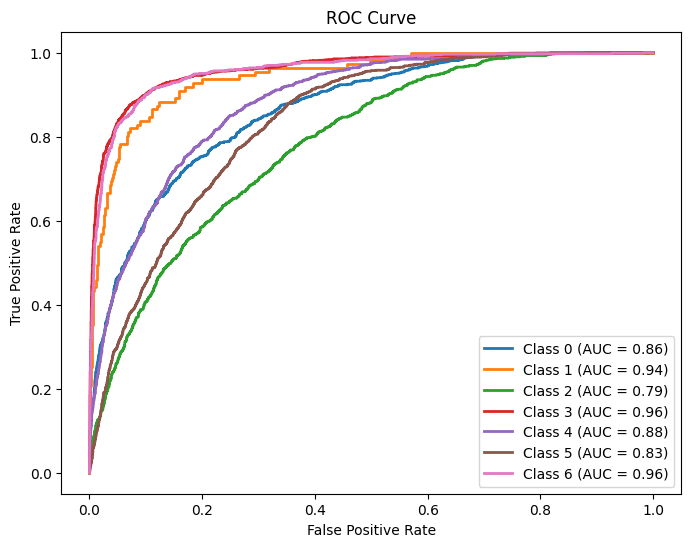

In [ ]:
# ROC Curve
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(output_class):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i in range(output_class):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="best")
plt.show()


Original Output: fear
1/1 [==============================] - 0s 24ms/step
Predicted Output: surprise


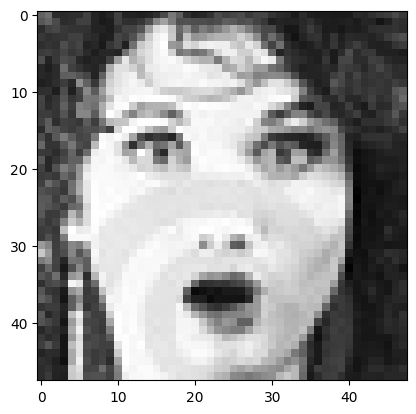

In [ ]:
# Test with Random Image
image_index = random.randint(0, len(test))
print("Original Output:", test['label'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray');